In [110]:
import numpy as np

num_samples = 200
item_idx = np.arange(num_samples)
covariate_1 = np.random.uniform(-0.5, 0.5, num_samples)

num_reads = 10
covariate_2 = np.random.choice([-0.50, 0.0, .50], (num_samples, num_reads), replace=True)
A, B, C = 100, 50, 520
response = covariate_1[:, None] * A  + covariate_2 * B + C + np.random.normal(0, 10, (num_samples, num_reads))


In [111]:
import pandas as pd

reads = pd.DataFrame(
    {
        "response": response.flatten(),
        "covariate_2": covariate_2.flatten(),
        "covariate_1": np.repeat(covariate_1, num_reads),
        "item_idx": np.repeat(item_idx, num_reads),
    }
)

train = reads.query("item_idx < 197")
test = reads.query("item_idx >= 197")

In [112]:
import numpyro
import numpyro.distributions as dist


def model(
    covariate_1,
    covariate_2,
    response=None,
):
    A = numpyro.sample("A", dist.Normal(0, 200))
    B = numpyro.sample("B", dist.Normal(0, 100))
    C = numpyro.sample("C", dist.Normal(0, 1000))
    noise = numpyro.sample("noise", dist.HalfNormal(scale=20))

    numpyro.sample(
        "response", dist.Normal(covariate_1 * A + covariate_2 * B + C, noise), obs=response
    )

In [113]:
from numpyro.infer import NUTS, MCMC
from jax import random

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 10000
mcmc = MCMC(kernel, 
            num_warmup=1000, 
            num_samples=num_samples,
            num_chains=2,
            thinning = 1)
mcmc.run(
    rng_key_, 
    covariate_2=train.covariate_2.values, 
    response=train.response.values, 
    covariate_1=train.covariate_1.values
)
mcmc.print_summary()
posterior = mcmc.get_samples()

/tmp/ipykernel_64674/3073248306.py:11: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel,
sample: 100%|██████████| 11000/11000 [00:01<00:00, 6813.80it/s, 3 steps of size 7.39e-01. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A     99.45      0.77     99.45     98.19    100.70  20366.41      1.00
         B     50.78      0.54     50.79     49.86     51.65  23427.80      1.00
         C    520.26      0.22    520.26    519.90    520.62  19276.30      1.00
     noise      9.65      0.15      9.65      9.41      9.91  24160.39      1.00

Number of divergences: 0


# Trace plot

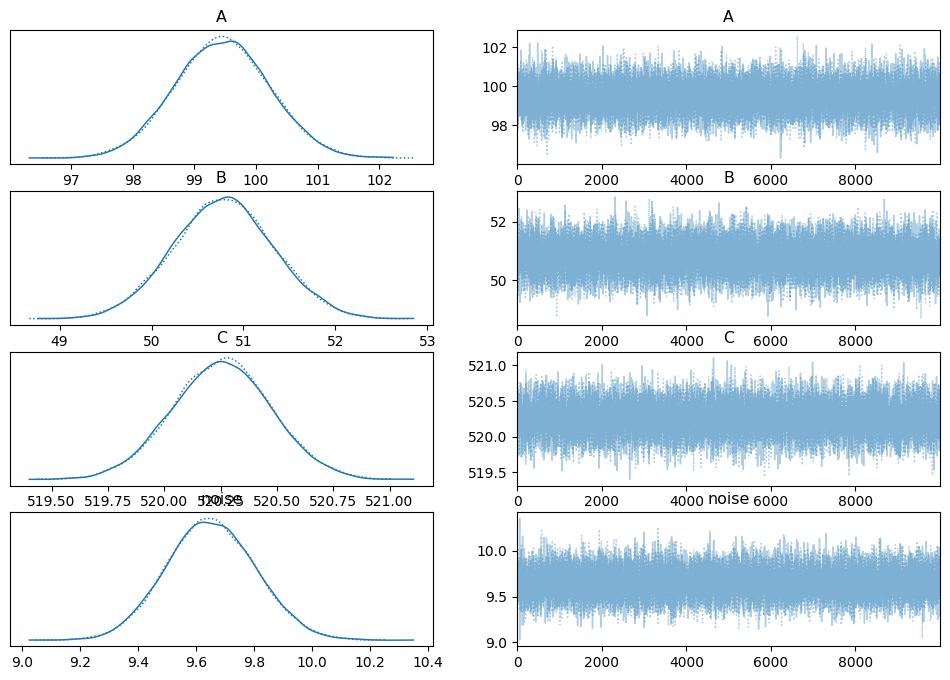

In [114]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);


# Pairs plot

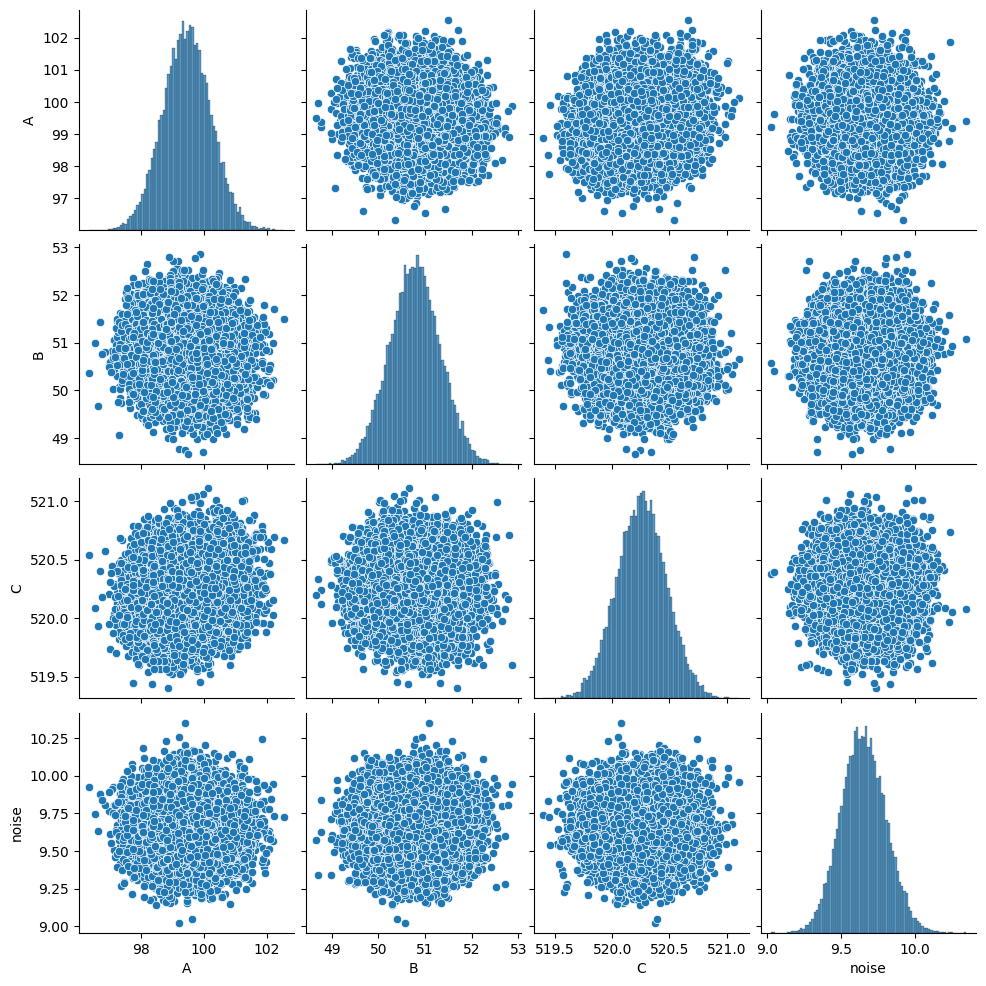

In [115]:
# Pairs plot
import seaborn as sns

vars = ["A", "B", "C", "noise"]
sns.pairplot(pd.DataFrame(posterior), x_vars=vars, y_vars=vars);


In [116]:
import altair as alt

def plot_regression(x, y, y_mean, y_hpdi):
    results = pd.DataFrame(
        {
            "Covariate": x,
            "Response": y,
            "Response (predicted)": y_mean,
            r"Response (5% confidence)": y_hpdi[0, :],
            r"Response (95% confidence)": y_hpdi[1, :],
        }
    )
    base = alt.Chart(results)

    return alt.layer(
        base.mark_circle().encode(
            alt.X("Covariate", scale=alt.Scale(zero=False)),
            alt.Y("Response", scale=alt.Scale(zero=False), title="Response"),
        ),
        base.mark_line().encode(
            x="Covariate",
            y=alt.Y("Response (predicted)", title="Response"),
        ),
        alt.Chart(results)
        .mark_area(opacity=0.3)
        .encode(
            x="Covariate",
            y=alt.Y(r"Response (5% confidence)", title="Response"),
            y2=alt.Y2(r"Response (95% confidence)", title="Response"),
        ),
    )

# Prior predictive checks

In [117]:
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(
    rng_key_,
    covariate_1=train.covariate_1.values,
    covariate_2=train.covariate_2.values,
)["response"]

mean_prior_pred = np.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

plot_regression(
    train.covariate_1.values, train.response.values, mean_prior_pred, hpdi_prior_pred
) | plot_regression(
    train.covariate_2.values, train.response.values, mean_prior_pred, hpdi_prior_pred
)

alt.HConcatChart(...)

# Posterior predictive checks

In [118]:
rng_key, rng_key_ = random.split(rng_key)
posterior_predictive = Predictive(model, posterior)
plots = []
for cov2, subset in train.groupby("covariate_2"):
    
    posterior_predictions = posterior_predictive(
        rng_key_,
        covariate_1=subset.covariate_1.values,
        covariate_2=cov2,
    )["response"]

    mean_posterior_pred = np.mean(posterior_predictions, axis=0)
    hpdi_posterior_pred = hpdi(posterior_predictions, 0.95)
    

    plots.append(plot_regression(
        subset.covariate_1.values, subset.response.values, mean_posterior_pred, hpdi_posterior_pred
    ).properties(title=f"covariate_2 = {cov2}"))

alt.hconcat(*plots)

alt.HConcatChart(...)

In [119]:
posterior_predictions.shape

(20000, 661)

# Posterior distributions

In [120]:
import altair as alt

base = alt.Chart(pd.DataFrame(posterior).head(5000)).mark_bar().encode(y="count()")
base.encode(
    x=alt.X("A:O").bin(maxbins=20),
) | base.encode(
    x=alt.X("B:O").bin(maxbins=20),
) | base.encode(
    x=alt.X("C:O").bin(maxbins=20),
) | base.encode(
    x=alt.X("noise:O").bin(maxbins=20),
)

alt.HConcatChart(...)

# Using coefficients as priors

In [121]:
truncnorm.fit(posterior["noise"])

(3.7559001524038766,
 38.10508775734145,
 -0.31128537808219603,
 2.4856567710550355)

In [122]:
from scipy.stats import norm, truncnorm

mu_A, sigma_A = norm.fit(posterior["A"])
mu_B, sigma_B = norm.fit(posterior["B"])
mu_C, sigma_C = norm.fit(posterior["C"])
mu_noise, sigma_noise, _, _ = truncnorm.fit(posterior["noise"])

In [128]:
import numpyro
import numpyro.distributions as dist

def item_model(covariate_2, response, mu_A, sigma_A, mu_B, sigma_B, mu_C, sigma_C):
    A = numpyro.sample("A", dist.Normal(mu_A, sigma_A))
    B = numpyro.sample("B", dist.Normal(mu_B, sigma_B))
    C = numpyro.sample("C", dist.Normal(mu_C, sigma_C))
    noise = numpyro.sample("noise", dist.TruncatedNormal(mu_noise, scale=sigma_noise))

    covariate_1 = numpyro.sample("covariate_1_to_fit", dist.Uniform(-0.5, 0.5))

    numpyro.sample("response", dist.Normal(covariate_1 * A + covariate_2 * B + C, noise), obs=response)


In [129]:

from numpyro.infer import NUTS, MCMC
from jax import random

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(item_model)
num_samples = 4000
mcmc = MCMC(kernel, 
            num_warmup=1000, 
            num_samples=num_samples,
            num_chains = 2)
for item_idx, test_item in test.groupby("item_idx"):
    print(item_idx)
    print(test_item.covariate_1.unique())
    mcmc.run(
        rng_key_,
        covariate_2=test_item.covariate_2.values,
        response=test_item.response.values,
        mu_A=mu_A,
        sigma_A=sigma_A,
        mu_B=mu_B,
        sigma_B=sigma_B,
        mu_C=mu_C,
        sigma_C=sigma_C,

    )
    mcmc.print_summary()

/tmp/ipykernel_64674/1248168136.py:11: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel,


197
[-0.46945502]


sample: 100%|██████████| 5000/5000 [00:00<00:00, 8843.56it/s, 7 steps of size 4.53e-01. acc. prob=0.92]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
                   A     99.46      0.76     99.47     98.24    100.74   9250.12      1.00
                   B     50.78      0.54     50.78     49.91     51.68   8586.20      1.00
                   C    520.25      0.22    520.25    519.89    520.62   8637.99      1.00
  covariate_1_to_fit     -0.46      0.02     -0.46     -0.49     -0.42   4114.19      1.00
               noise      6.18      1.74      5.85      3.59      8.57   3162.16      1.00

Number of divergences: 0
198
[0.31256842]


sample: 100%|██████████| 5000/5000 [00:00<00:00, 9234.76it/s, 7 steps of size 5.08e-01. acc. prob=0.91]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
                   A     99.45      0.77     99.45     98.25    100.77   7283.49      1.00
                   B     50.74      0.55     50.73     49.80     51.59   7400.36      1.00
                   C    520.26      0.22    520.25    519.90    520.62   7419.29      1.00
  covariate_1_to_fit      0.33      0.03      0.33      0.28      0.38   6124.56      1.00
               noise      9.62      2.71      9.10      5.54     13.35   3728.63      1.00

Number of divergences: 0
199
[0.31794018]


sample: 100%|██████████| 5000/5000 [00:00<00:00, 9391.24it/s, 7 steps of size 4.21e-01. acc. prob=0.92]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
                   A     99.45      0.77     99.44     98.17    100.72   7954.84      1.00
                   B     50.84      0.54     50.85     49.95     51.73   8110.53      1.00
                   C    520.25      0.22    520.25    519.89    520.60   7890.88      1.00
  covariate_1_to_fit      0.32      0.04      0.33      0.26      0.39   6736.65      1.00
               noise     12.17      3.39     11.55      7.40     17.10   3580.33      1.00

Number of divergences: 1


# Sample static coefficient distribution

In [125]:
from functools import partial 

from numpyro.infer import MCMC, NUTS, HMCGibbs


def item_model(param, response, mu_A, sigma_A, mu_B, sigma_B, mu_C, sigma_C):
    A = numpyro.sample("A", dist.Normal(mu_A, sigma_A))
    B = numpyro.sample("B", dist.Normal(mu_B, sigma_B))
    C = numpyro.sample("C", dist.Normal(mu_C, sigma_C))

    item = numpyro.sample("item", dist.Uniform(0, 1))

    numpyro.sample("response", dist.Normal(item * A + param * B + C, 0.2), obs=response)

# def gibbs_fn(rng_key, gibbs_sites, hmc_sites, mu_A, sigma_A, mu_B, sigma_B, mu_C, sigma_C):
#     return {
#         'A': dist.Normal(mu_A, sigma_A).sample(rng_key),
#         'B': dist.Normal(mu_B, sigma_B).sample(rng_key),
#         'C': dist.Normal(mu_C, sigma_C).sample(rng_key),
#     }
def gibbs_fn(rng_key, gibbs_sites, hmc_sites, mu_A, sigma_A, mu_B, sigma_B, mu_C, sigma_C):
    return {
        'A': np.random.choice(posterior["A"], gibbs_sites["A"].shape),
        'B': np.random.choice(posterior["B"], gibbs_sites["B"].shape),
        'C': np.random.choice(posterior["C"], gibbs_sites["C"].shape),
    }

hmc_kernel = NUTS(item_model)
kernel = HMCGibbs(
    hmc_kernel,
    gibbs_fn=partial(
        gibbs_fn,
        mu_A=mu_A,
        sigma_A=sigma_A,
        mu_B=mu_B,
        sigma_B=sigma_B,
        mu_C=mu_C,
        sigma_C=sigma_C,
    ),
    gibbs_sites=['A', 'B', 'C']
)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, progress_bar=False)
for item_idx, test_item in test.groupby("item_idx"):
    print(item_idx)
    print(test_item.item)
    mcmc.run(
        rng_key_,
        param=test_item.param.values,
        response=test_item.response.values,
        mu_A=mu_A,
        sigma_A=sigma_A,
        mu_B=mu_B,
        sigma_B=sigma_B,
        mu_C=mu_C,
        sigma_C=sigma_C,

    )
    mcmc.print_summary()

197


AttributeError: 'DataFrame' object has no attribute 'item'

# Inference all together

In [ ]:
import numpyro
import numpyro.distributions as dist

def model(param, response, item):
    A = numpyro.sample("A", dist.Normal(0, 200))
    B = numpyro.sample("B", dist.Normal(0, 1))
    C = numpyro.sample("C", dist.Normal(0, 100))

    for i in range(len(item)):

    numpyro.sample("response", dist.Normal(item * A + param * B + C, 1), obs=response)


In [ ]:
from numpyro.infer import NUTS, MCMC
from jax import random

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 6000
mcmc = MCMC(kernel, num_warmup=2000, num_samples=num_samples)
mcmc.run(
    rng_key_, param=train.param.values, response=train.response.values, item=train.item.values
)
mcmc.print_summary()
posterior = mcmc.get_samples()

sample: 100%|██████████| 8000/8000 [00:12<00:00, 650.33it/s, 7 steps of size 1.68e-03. acc. prob=0.92]   



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A     99.41      0.08     99.41     99.26     99.53    840.58      1.00
         B      0.49      0.00      0.49      0.49      0.49   2731.59      1.00
         C     54.93      0.47     54.92     54.16     55.69   2697.88      1.00

Number of divergences: 0
